In [1]:
!pip install transformers
!pip install datasets

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel
from datasets import load_dataset
from PIL import Image
from tqdm import tqdm
import numpy as np
import pandas as pd


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 15.5 MB/s eta 0:00:0000:01
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 1.0.0rc2
    Uninstalling huggingface-hub-1.0.0rc2:
      Successfully uninstalled huggingface-hub-1.0.0rc2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.1.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
gradio 5.38.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.0a1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 45.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 19.0.1
    Uninstalling pyarrow-19.0.1:
      Successfully uninstalled pyarrow-19.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are install

2025-10-16 04:07:59.209138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760587679.449954      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760587679.523874      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# --- 1. Setup and Configuration ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Configuration
ALL_DOMAINS = ['photo', 'art_painting', 'cartoon', 'sketch']
SOURCE_DOMAINS = ['photo', 'art_painting', 'cartoon']
TARGET_DOMAIN = 'sketch'
PACS_CLASSES = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
BATCH_SIZE = 64
EPOCHS_LINEAR_PROBE = 10
LEARNING_RATE = 1e-3

Using device: cuda


In [3]:
# --- 2. Load CLIP Model ---
print("Loading CLIP ViT-B/32 model...")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval()

# --- 3. Data Handling using Hugging Face datasets ---
print("Loading PACS dataset from Hugging Face Hub...")
full_dataset_dict = load_dataset("flwrlabs/pacs")
full_dataset = full_dataset_dict['train']
print("Dataset features:", full_dataset.features)

class HFPACSDataset(Dataset):
    """A PyTorch Dataset wrapper that filters the HF dataset by domain string."""
    def __init__(self, hf_dataset, domains_to_include, transform=None):
        self.filtered_dataset = hf_dataset.filter(
            lambda example: example['domain'] in domains_to_include
        )
        self.transform = transform
    def __len__(self):
        return len(self.filtered_dataset)
    def __getitem__(self, idx):
        item = self.filtered_dataset[idx]
        image = item['image'].convert("RGB")
        label = item['label']
        if self.transform:
            image = self.transform(image)
        return image, label

clip_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

Loading CLIP ViT-B/32 model...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Loading PACS dataset from Hugging Face Hub...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9991 [00:00<?, ? examples/s]

Dataset features: {'image': Image(mode=None, decode=True), 'domain': Value('string'), 'label': ClassLabel(names=['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person'])}


In [4]:
# Part 1: Zero-Shot Evaluation
def evaluate_zeroshot(model, processor, dataloader, prompts, domain_name):
    model.eval()
    text_inputs = processor(text=prompts, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        text_embeddings = model.get_text_features(**text_inputs)
        text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Zero-shot on {domain_name}"):
            images, labels = images.to(device), labels.to(device)
            image_embeddings = model.get_image_features(images)
            image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)
            similarities = (100.0 * image_embeddings @ text_embeddings.T).softmax(dim=-1)
            _, predictions = similarities.max(1)
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
    return 100 * correct / total

# Part 2: Linear Probing
class LinearProbe(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LinearProbe, self).__init__()
        self.classifier = nn.Linear(input_dim, num_classes)
    def forward(self, x):
        return self.classifier(x)

def train_linear_probe(clip_model, probe_model, dataloader, epochs, lr):
    clip_model.eval()
    probe_model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(probe_model.parameters(), lr=lr)
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in tqdm(dataloader, desc=f"Training Probe Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.no_grad():
                image_features = clip_model.get_image_features(images)
            outputs = probe_model(image_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(dataloader):.4f}")
    return probe_model

def evaluate_linear_probe(clip_model, probe_model, dataloader, domain_name):
    clip_model.eval()
    probe_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Evaluating Probe on {domain_name}"):
            images, labels = images.to(device), labels.to(device)
            image_features = clip_model.get_image_features(images)
            outputs = probe_model(image_features)
            _, predictions = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
    return 100 * correct / total

# Part 3: Prompt Learning for Domain Adaptation
# Implementation 1: "Simple" Pseudo Learnable Prompts (NOT CORRECT)
class SimpleLearnablePrompts(nn.Module):
    """Learn prompt embeddings that adapt CLIP for domain shift."""
    def __init__(self, clip_model, processor, class_names, n_ctx=4, device='cuda'):
        super().__init__()
        self.clip_model = clip_model
        self.processor = processor
        self.class_names = class_names
        self.device = device
        
        # Text feature dimension (512 for ViT-B/32)
        text_dim = clip_model.text_projection.out_features
        
        # Learnable prompt embeddings
        self.prompt_embeddings = nn.Parameter(
            torch.randn(len(class_names), text_dim) * 0.02
        )
        
        # Get fixed base text features
        with torch.no_grad():
            base_prompts = [f"a photo of a {name}." for name in class_names]
            text_inputs = processor(text=base_prompts, return_tensors="pt", padding=True).to(device)
            self.register_buffer(
                "base_text_features",
                clip_model.get_text_features(**text_inputs)
            )
            self.base_text_features = self.base_text_features / self.base_text_features.norm(dim=-1, keepdim=True)
        
        print(f"Learnable prompt parameters: {self.prompt_embeddings.numel()}")
    
    def forward(self):
        """Returns adapted text features."""
        text_features = self.base_text_features + self.prompt_embeddings
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        return text_features


def train_prompt_learning(clip_model, processor, source_loader, class_names, 
                         n_ctx=4, epochs=10, lr=0.002, device='cuda'):
    """Train learnable prompts on source domain."""
    
    prompt_model = SimpleLearnablePrompts(
        clip_model, processor, class_names, n_ctx=n_ctx, device=device
    ).to(device)
    
    # Freeze CLIP completely
    for param in clip_model.parameters():
        param.requires_grad = False
    
    # Only optimize prompts
    optimizer = optim.Adam([prompt_model.prompt_embeddings], lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    criterion = nn.CrossEntropyLoss()
    
    print(f"\n{'='*60}")
    print(f"Training Prompt Learning")
    print(f"{'='*60}")
    print(f"Trainable parameters: {prompt_model.prompt_embeddings.numel()}")
    print(f"CLIP parameters (frozen): {sum(p.numel() for p in clip_model.parameters())}")
    print(f"{'='*60}\n")
    
    best_acc = 0.0
    
    for epoch in range(epochs):
        prompt_model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in tqdm(source_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Get image features (frozen CLIP)
            with torch.no_grad():
                image_features = clip_model.get_image_features(images)
                image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            
            # Get learned text features
            text_features = prompt_model()
            
            # Compute loss
            logits = 100.0 * image_features @ text_features.T
            loss = criterion(logits, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        scheduler.step()
        
        avg_loss = running_loss / len(source_loader)
        accuracy = 100. * correct / total
        
        if accuracy > best_acc:
            best_acc = accuracy
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}: Loss: {avg_loss:.4f}, Acc: {accuracy:.2f}% (Best: {best_acc:.2f}%)")
    
    return prompt_model


def evaluate_prompt_learning(clip_model, prompt_model, dataloader, domain_name, device='cuda'):
    """Evaluate learned prompts."""
    clip_model.eval()
    prompt_model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        text_features = prompt_model()
        
        for images, labels in tqdm(dataloader, desc=f"Eval on {domain_name}"):
            images, labels = images.to(device), labels.to(device)
            
            image_features = clip_model.get_image_features(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            
            logits = 100.0 * image_features @ text_features.T
            _, predicted = logits.max(1)
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return 100. * correct / total

# Implementation 2: CoOp Based Prompt Learning (CORRECT)
class SafeCoOpPrompts(nn.Module):
    """
    Safe implementation of CoOp that avoids CUDA indexing issues.
    """
    def __init__(self, clip_model, class_names, n_ctx=16, device='cuda'):
        super().__init__()
        self.n_ctx = n_ctx
        self.n_cls = len(class_names)
        self.device = device
        self.clip_model = clip_model
        
        # Embedding dimension
        self.ctx_dim = 512  # ViT-B/32
        
        print(f"\nInitializing Safe CoOp:")
        print(f"  Context tokens: {n_ctx}")
        print(f"  Classes: {self.n_cls}")
        print(f"  Embedding dimension: {self.ctx_dim}")
        
        # Initialize context vectors - SIMPLE random initialization
        ctx_vectors = torch.randn(n_ctx, self.ctx_dim, dtype=torch.float32) * 0.02
        self.ctx = nn.Parameter(ctx_vectors)
        
        # Get CLIP's tokenizer
        from transformers import CLIPTokenizer
        tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
        
        # Create simple prompts: "X X X ... X classname"
        prompts = []
        for name in class_names:
            # Create prompt with n_ctx 'X' tokens followed by class name
            ctx_placeholder = " ".join(["X"] * n_ctx)
            prompts.append(f"{ctx_placeholder} {name}.")
        
        # Tokenize on CPU first to avoid CUDA issues
        tokenized = tokenizer(
            prompts, 
            padding=True, 
            return_tensors="pt",
            truncation=True,
            max_length=77  # CLIP's max length
        )
        
        # Move to device safely
        token_ids = tokenized['input_ids'].to(device)
        
        # Get embeddings
        with torch.no_grad():
            embeddings = clip_model.text_model.embeddings.token_embedding(token_ids)
        
        # Extract parts
        # [SOS] is at position 0
        # Context placeholders are at positions 1 to n_ctx
        # Class tokens and [EOS] are after that
        
        prefix = embeddings[:, :1, :].clone()  # [SOS]
        suffix = embeddings[:, 1 + n_ctx:, :].clone()  # class + . + [EOS] + padding
        
        # Register as buffers
        self.register_buffer("token_prefix", prefix)
        self.register_buffer("token_suffix", suffix)
        
        # Find [EOS] positions - do this carefully on CPU
        eos_token_id = tokenizer.eos_token_id
        token_ids_cpu = token_ids.cpu()
        
        eos_positions = []
        for i in range(self.n_cls):
            # Find where EOS token is
            eos_pos = (token_ids_cpu[i] == eos_token_id).nonzero(as_tuple=True)[0]
            if len(eos_pos) > 0:
                eos_positions.append(eos_pos[0].item())
            else:
                # Fallback: use last position
                eos_positions.append(token_ids_cpu.shape[1] - 1)
        
        self.register_buffer("eos_positions", torch.tensor(eos_positions, dtype=torch.long, device=device))
        
        print(f"  Trainable parameters: {self.ctx.numel():,}")
        print(f"  EOS positions: {eos_positions}")
        print(f"  Initialization complete!")
    
    def forward(self):
        """Forward pass through text encoder."""
        # Expand context to all classes
        ctx = self.ctx.unsqueeze(0).expand(self.n_cls, -1, -1)  # [n_cls, n_ctx, dim]
        
        # Construct full embeddings
        prefix = self.token_prefix  # [n_cls, 1, dim]
        suffix = self.token_suffix  # [n_cls, seq_len, dim]
        
        prompts = torch.cat([prefix, ctx, suffix], dim=1)  # [n_cls, total_len, dim]
        
        # Add positional embeddings
        seq_len = prompts.shape[1]
        position_ids = torch.arange(seq_len, device=self.device).unsqueeze(0).expand(self.n_cls, -1)
        position_embeddings = self.clip_model.text_model.embeddings.position_embedding(position_ids)
        
        embeddings = prompts + position_embeddings
        
        # Pass through text encoder
        encoder_out = self.clip_model.text_model.encoder(
            embeddings,
            attention_mask=None,
            causal_attention_mask=None,
        )
        
        hidden_states = encoder_out[0]  # [n_cls, seq_len, dim]
        
        # Extract features at EOS positions
        batch_indices = torch.arange(self.n_cls, device=self.device)
        text_features = hidden_states[batch_indices, self.eos_positions]

        # Apply final processing
        text_features = self.clip_model.text_model.final_layer_norm(text_features)
        text_features = self.clip_model.text_projection(text_features)

        # Normalize
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        return text_features


def train_safe_coop(clip_model, coop_model, train_loader, epochs=10, lr=0.002, device='cuda'):
    """Train CoOp safely."""
    
    # Freeze CLIP
    for param in clip_model.parameters():
        param.requires_grad = False
    
    # Verify only context is trainable
    print(f"\nTraining setup:")
    print(f"  Optimizing: {coop_model.ctx.numel():,} parameters")
    print(f"  Context requires_grad: {coop_model.ctx.requires_grad}")
    
    optimizer = optim.SGD([coop_model.ctx], lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    criterion = nn.CrossEntropyLoss()
    
    print(f"\nStarting training for {epochs} epochs...")
    
    for epoch in range(epochs):
        coop_model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Get image features (frozen CLIP)
            with torch.no_grad():
                image_features = clip_model.get_image_features(images)
                image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            
            # Get text features (learnable prompts)
            text_features = coop_model()
            
            # Compute loss
            logits = 100.0 * image_features @ text_features.T
            loss = criterion(logits, labels)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping (helps stability)
            torch.nn.utils.clip_grad_norm_([coop_model.ctx], max_norm=1.0)
            
            optimizer.step()
            
            # Stats
            total_loss += loss.item()
            _, pred = logits.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})
        
        scheduler.step()
        
        avg_loss = total_loss / len(train_loader)
        acc = 100. * correct / total
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}: Loss={avg_loss:.4f}, Acc={acc:.2f}%")
    
    return coop_model


def evaluate_safe_coop(clip_model, coop_model, dataloader, domain_name, device='cuda'):
    """Evaluate CoOp safely."""
    clip_model.eval()
    coop_model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        # Get text features once
        text_features = coop_model()
        
        for images, labels in tqdm(dataloader, desc=f"Eval {domain_name}"):
            images = images.to(device)
            labels = labels.to(device)
            
            # Get image features
            image_features = clip_model.get_image_features(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            
            # Predict
            logits = 100.0 * image_features @ text_features.T
            _, pred = logits.max(1)
            
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()
    
    acc = 100. * correct / total
    print(f"{domain_name} Accuracy: {acc:.2f}%")
    return acc


In [5]:
print("\n--- Running Part 1: Comprehensive Zero-Shot Evaluation ---")

zeroshot_results = []

# Loop over ALL domains for a full evaluation
for domain_name in ALL_DOMAINS:
    print(f"\nEvaluating domain: {domain_name.upper()}")
    
    # Create dataset and loader for the current domain
    domain_dataset = HFPACSDataset(full_dataset, [domain_name], transform=clip_transform)
    domain_loader = DataLoader(domain_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Define prompts
    generic_prompt = [f"a photo of a {c}." for c in PACS_CLASSES]
    specific_prompt = [f"a {domain_name.replace('_', ' ')} of a {c}." for c in PACS_CLASSES]
    
    # Evaluate with both prompt types
    generic_acc = evaluate_zeroshot(clip_model, processor, domain_loader, generic_prompt, domain_name)
    specific_acc = evaluate_zeroshot(clip_model, processor, domain_loader, specific_prompt, domain_name)
    
    zeroshot_results.append({
        "Domain": domain_name,
        "Generic Prompt ('photo') Acc": f"{generic_acc:.2f}%",
        "Domain-Specific Prompt Acc": f"{specific_acc:.2f}%"
    })

# Display results in a clean table using pandas
zeroshot_df = pd.DataFrame(zeroshot_results)
print("\n--- Zero-Shot Performance Summary ---")
print(zeroshot_df.to_string(index=False))


print("\n--- Running Part 2: Linear Probing (Fine-tuning) ---")

# Create the source and target datasets/loaders for the experiment
source_dataset = HFPACSDataset(full_dataset, SOURCE_DOMAINS, transform=clip_transform)
target_dataset = HFPACSDataset(full_dataset, [TARGET_DOMAIN], transform=clip_transform)
source_loader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True)
target_loader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nSource domains for training: {', '.join(SOURCE_DOMAINS)} ({len(source_dataset)} images)")
print(f"Target domain for evaluation: {TARGET_DOMAIN} ({len(target_dataset)} images)")

# Initialize and train the linear probe
feature_dim = clip_model.projection_dim
linear_probe = LinearProbe(feature_dim, len(PACS_CLASSES)).to(device)
trained_probe = train_linear_probe(clip_model, linear_probe, source_loader, EPOCHS_LINEAR_PROBE, LEARNING_RATE)

# Evaluate on the unseen TARGET domain
probe_target_accuracy = evaluate_linear_probe(clip_model, trained_probe, target_loader, f"Target ({TARGET_DOMAIN})")

# ALSO, evaluate on the SOURCE domains it was trained on to check for overfitting
probe_source_accuracy = evaluate_linear_probe(clip_model, trained_probe, source_loader, "Source Domains")

print("\n--- Linear Probe Performance Summary ---")
print(f"Source Domains (Training Accuracy): {probe_source_accuracy:.2f}%")
print(f"Target Domain ('{TARGET_DOMAIN}') Accuracy: {probe_target_accuracy:.2f}%")

print("\n" + "="*70)
print("PART 3: PROMPT LEARNING FOR DOMAIN ADAPTATION")
print("="*70)

# Train prompt learning on source domains
trained_prompt_model = train_prompt_learning(
    clip_model=clip_model,
    processor=processor,
    source_loader=source_loader,
    class_names=PACS_CLASSES,
    n_ctx=4,
    epochs=10,
    lr=0.002,
    device=device
)

print("\n" + "-"*70)
print("EVALUATING PROMPT LEARNING")
print("-"*70)

# Evaluate on source (to check if it learned)
source_prompt_acc = evaluate_prompt_learning(
    clip_model, trained_prompt_model, source_loader, "Source Domains", device
)

# Evaluate on target (the main result)
target_prompt_acc = evaluate_prompt_learning(
    clip_model, trained_prompt_model, target_loader, TARGET_DOMAIN, device
)

print(f"\nPrompt Learning Results:")
print(f"  Source Domains: {source_prompt_acc:.2f}%")
print(f"  Target Domain ({TARGET_DOMAIN}): {target_prompt_acc:.2f}%")

print("\n" + "="*70)
print("PART 3: CoOp (Safe Implementation)")
print("="*70)

# try:
# Initialize
coop_model = SafeCoOpPrompts(
    clip_model=clip_model,
    class_names=PACS_CLASSES,
    n_ctx=16,
    device=device
).to(device)

# Train
print("\nTraining on source domains...")
trained_coop = train_safe_coop(
    clip_model=clip_model,
    coop_model=coop_model,
    train_loader=source_loader,
    epochs=10,
    lr=0.002,
    device=device
)

# Evaluate
print("\n" + "-"*70)
print("Evaluation")
print("-"*70)

source_acc = evaluate_safe_coop(clip_model, trained_coop, source_loader, "Source", device)
target_acc = evaluate_safe_coop(clip_model, trained_coop, target_loader, TARGET_DOMAIN, device)

print("\n" + "="*70)
print("Results")
print("="*70)
print(f"Source Accuracy: {source_acc:.2f}%")
print(f"Target Accuracy ({TARGET_DOMAIN}): {target_acc:.2f}%")
    
# except Exception as e:
#     print(f"\nError occurred: {e}")
#     import traceback
#     traceback.print_exc()
    
#     # Try to clear CUDA cache
#     print("\nClearing CUDA cache...")
#     torch.cuda.empty_cache()


--- Running Part 1: Comprehensive Zero-Shot Evaluation ---

Evaluating domain: PHOTO


Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Zero-shot on photo: 100%|██████████| 27/27 [00:07<00:00,  3.72it/s]


Evaluating domain: ART_PAINTING


Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Zero-shot on art_painting: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Evaluating domain: CARTOON


Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Zero-shot on cartoon: 100%|██████████| 37/37 [00:09<00:00,  3.96it/s]


Evaluating domain: SKETCH


Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Zero-shot on sketch: 100%|██████████| 62/62 [00:16<00:00,  3.78it/s]


--- Zero-Shot Performance Summary ---
      Domain Generic Prompt ('photo') Acc Domain-Specific Prompt Acc
       photo                       99.82%                     99.82%
art_painting                       96.29%                     95.36%
     cartoon                       98.17%                     97.91%
      sketch                       85.19%                     85.42%

--- Running Part 2: Linear Probing (Fine-tuning) ---


Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]


Source domains for training: photo, art_painting, cartoon (6062 images)
Target domain for evaluation: sketch (3929 images)


Training Probe Epoch 1/10: 100%|██████████| 95/95 [00:24<00:00,  3.87it/s]


Epoch 1, Loss: 0.7696


Training Probe Epoch 2/10: 100%|██████████| 95/95 [00:24<00:00,  3.87it/s]


Epoch 2, Loss: 0.1963


Training Probe Epoch 3/10: 100%|██████████| 95/95 [00:24<00:00,  3.84it/s]


Epoch 3, Loss: 0.1205


Training Probe Epoch 4/10: 100%|██████████| 95/95 [00:24<00:00,  3.86it/s]


Epoch 4, Loss: 0.0900


Training Probe Epoch 5/10: 100%|██████████| 95/95 [00:24<00:00,  3.85it/s]


Epoch 5, Loss: 0.0733


Training Probe Epoch 6/10: 100%|██████████| 95/95 [00:24<00:00,  3.86it/s]


Epoch 6, Loss: 0.0622


Training Probe Epoch 7/10: 100%|██████████| 95/95 [00:24<00:00,  3.87it/s]


Epoch 7, Loss: 0.0543


Training Probe Epoch 8/10: 100%|██████████| 95/95 [00:24<00:00,  3.84it/s]


Epoch 8, Loss: 0.0483


Training Probe Epoch 9/10: 100%|██████████| 95/95 [00:24<00:00,  3.86it/s]


Epoch 9, Loss: 0.0435


Training Probe Epoch 10/10: 100%|██████████| 95/95 [00:24<00:00,  3.84it/s]


Epoch 10, Loss: 0.0396


Evaluating Probe on Source Domains: 100%|██████████| 95/95 [00:24<00:00,  3.85it/s]



--- Linear Probe Performance Summary ---
Source Domains (Training Accuracy): 99.44%
Target Domain ('sketch') Accuracy: 84.22%

PART 3: PROMPT LEARNING FOR DOMAIN ADAPTATION
Learnable prompt parameters: 3584

Training Prompt Learning
Trainable parameters: 3584
CLIP parameters (frozen): 151277313



Epoch   1: Loss: 0.0646, Acc: 97.89% (Best: 97.89%)


Epoch  10: Loss: 0.0023, Acc: 100.00% (Best: 100.00%)

----------------------------------------------------------------------
EVALUATING PROMPT LEARNING
----------------------------------------------------------------------


Eval on sketch: 100%|██████████| 62/62 [00:17<00:00,  3.53it/s]



Prompt Learning Results:
  Source Domains: 100.00%
  Target Domain (sketch): 84.60%

PART 3: CoOp (Safe Implementation)

Initializing Safe CoOp:
  Context tokens: 16
  Classes: 7
  Embedding dimension: 512
  Trainable parameters: 8,192
  EOS positions: [19, 19, 19, 19, 19, 19, 19]
  Initialization complete!

Training on source domains...

Training setup:
  Optimizing: 8,192 parameters
  Context requires_grad: True

Starting training for 10 epochs...


Epoch   1: Loss=0.1447, Acc=96.16%


Epoch  10: Loss=0.0232, Acc=99.24%

----------------------------------------------------------------------
Evaluation
----------------------------------------------------------------------


Eval Source: 100%|██████████| 95/95 [00:25<00:00,  3.67it/s]


Source Accuracy: 99.26%


Eval sketch: 100%|██████████| 62/62 [00:17<00:00,  3.57it/s]

sketch Accuracy: 83.33%

Results
Source Accuracy: 99.26%
Target Accuracy (sketch): 83.33%


In [5]:
# ============================================================================
# PART 3 (Correction): PROMPT LEARNING WITH UNSUPERVISED ADAPTATION
# This new training function incorporates pseudo-labeling on the target domain.
# ============================================================================

source_dataset = HFPACSDataset(full_dataset, SOURCE_DOMAINS, transform=clip_transform)
target_dataset = HFPACSDataset(full_dataset, [TARGET_DOMAIN], transform=clip_transform)
source_loader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True)
target_loader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=False)

def train_coop_with_pseudo_labels(
    clip_model,
    coop_model,
    source_loader,
    target_loader, # Added target loader
    epochs=50,
    lr=0.002,
    lambda_pl=0.5, # Weight for the pseudo-label loss
    confidence_threshold=0.7, # Confidence threshold for pseudo-labels
    device='cuda'
):
    """Train CoOp with both source supervision and target pseudo-labeling."""

    # Freeze CLIP
    for param in clip_model.parameters():
        param.requires_grad = False

    optimizer = optim.SGD([coop_model.ctx], lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    criterion = nn.CrossEntropyLoss()
    
    print(f"\nStarting training with Pseudo-Labeling for {epochs} epochs...")
    print(f"  Pseudo-label loss weight (lambda_pl): {lambda_pl}")
    print(f"  Confidence threshold: {confidence_threshold}")

    target_iter = iter(target_loader)

    for epoch in range(epochs):
        coop_model.train()
        total_source_loss = 0
        total_pl_loss = 0
        correct = 0
        total = 0
        
        pbar = tqdm(source_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for images_src, labels_src in pbar:
            # Load a batch of target data
            try:
                images_tgt, _ = next(target_iter)
            except StopIteration:
                target_iter = iter(target_loader)
                images_tgt, _ = next(target_iter)

            images_src, labels_src = images_src.to(device), labels_src.to(device)
            images_tgt = images_tgt.to(device)

            optimizer.zero_grad()

            # --- Source Domain (Supervised Loss) ---
            with torch.no_grad():
                image_features_src = clip_model.get_image_features(images_src)
                image_features_src /= image_features_src.norm(dim=-1, keepdim=True)
            
            text_features = coop_model()
            logits_src = 100.0 * image_features_src @ text_features.T
            loss_src = criterion(logits_src, labels_src)
            
            # --- Target Domain (Unsupervised Pseudo-Label Loss) ---
            loss_pl = torch.tensor(0.0, device=device)
            with torch.no_grad():
                image_features_tgt = clip_model.get_image_features(images_tgt)
                image_features_tgt /= image_features_tgt.norm(dim=-1, keepdim=True)
                
                logits_tgt = 100.0 * image_features_tgt @ text_features.T
                probs_tgt = logits_tgt.softmax(dim=-1)
                
                max_probs, pseudo_labels = probs_tgt.max(dim=-1)
                mask = max_probs > confidence_threshold
            
            if mask.any():
                # Only compute loss on high-confidence samples
                logits_tgt_filtered = 100.0 * image_features_tgt[mask] @ text_features.T
                loss_pl = criterion(logits_tgt_filtered, pseudo_labels[mask])

            # --- Combined Loss ---
            total_loss = loss_src + lambda_pl * loss_pl
            
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_([coop_model.ctx], max_norm=1.0)
            optimizer.step()

            # Stats
            total_source_loss += loss_src.item()
            if mask.any():
                total_pl_loss += loss_pl.item()
            
            _, pred = logits_src.max(1)
            total += labels_src.size(0)
            correct += pred.eq(labels_src).sum().item()
            
            pbar.set_postfix({
                'src_loss': f'{loss_src.item():.4f}', 
                'pl_loss': f'{loss_pl.item():.4f}',
                'src_acc': f'{100.*correct/total:.2f}%'
            })
        
        scheduler.step()
        
        avg_loss = total_source_loss / len(source_loader)
        acc = 100. * correct / total
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}: Avg Src Loss={avg_loss:.4f}, Src Acc={acc:.2f}%")
            
    return coop_model


coop_model = SafeCoOpPrompts(
    clip_model=clip_model,
    class_names=PACS_CLASSES,
    n_ctx=16,
    device=device
).to(device)

trained_coop_pl = train_coop_with_pseudo_labels(
    clip_model=clip_model,
    coop_model=coop_model, # A freshly initialized CoOp model
    source_loader=source_loader,
    target_loader=target_loader,
    epochs=1,
    lr=0.002,
    device=device
)

Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]


Initializing Safe CoOp:
  Context tokens: 16
  Classes: 7
  Embedding dimension: 512
  Trainable parameters: 8,192
  EOS positions: [19, 19, 19, 19, 19, 19, 19]
  Initialization complete!

Starting training with Pseudo-Labeling for 1 epochs...
  Pseudo-label loss weight (lambda_pl): 0.5
  Confidence threshold: 0.7


Epoch   1: Avg Src Loss=0.1320, Src Acc=96.77%


In [7]:
# --- Evaluating the Pseudo-Label Trained Model ---
print("\n--- Evaluating CoOp model trained with Pseudo-Labels ---")

# Use the standard evaluation function. It will measure accuracy against the TRUE labels.
target_acc_pl = evaluate_safe_coop(
    clip_model=clip_model, 
    coop_model=trained_coop_pl, # Pass the model trained with pseudo-labels
    dataloader=target_loader,    # Evaluate on the target test set
    domain_name=f"{TARGET_DOMAIN} (after Pseudo-Labeling)", 
    device=device
)

print("\n" + "="*50)
print(f"Final Target Accuracy with Pseudo-Labeling: {target_acc_pl:.2f}%")
print("="*50)


--- Evaluating CoOp model trained with Pseudo-Labels ---


Eval sketch (after Pseudo-Labeling): 100%|██████████| 62/62 [00:17<00:00,  3.56it/s]

sketch (after Pseudo-Labeling) Accuracy: 90.00%

Final Target Accuracy with Pseudo-Labeling: 90.00%


In [10]:
# PART 4: GRADIENT CONFLICT AND ALIGNMENT ANALYSIS

import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*70)
print("PART 4: GRADIENT CONFLICT AND ALIGNMENT ANALYSIS")
print("="*70)

# ============================================================================
# Step 1: Create Domain-Specific Data Loaders
# ============================================================================

print("\nStep 1: Creating domain-specific loaders...")

# We'll analyze two source domains: photo and art_painting
DOMAIN_A = 'photo'
# DOMAIN_B = 'art_painting'
DOMAIN_B = 'sketch'

domain_a_dataset = HFPACSDataset(full_dataset, [DOMAIN_A], transform=clip_transform)
domain_b_dataset = HFPACSDataset(full_dataset, [DOMAIN_B], transform=clip_transform)

domain_a_loader = DataLoader(domain_a_dataset, batch_size=BATCH_SIZE, shuffle=True)
domain_b_loader = DataLoader(domain_b_dataset, batch_size=BATCH_SIZE, shuffle=True)

domain_loaders = {
    DOMAIN_A: domain_a_loader,
    DOMAIN_B: domain_b_loader
}

print(f"  {DOMAIN_A}: {len(domain_a_dataset)} images")
print(f"  {DOMAIN_B}: {len(domain_b_dataset)} images")

# ============================================================================
# Step 2: Initialize a Fresh CoOp Model for Analysis
# ============================================================================

print("\nStep 2: Initializing fresh CoOp model for gradient analysis...")

analysis_coop = SafeCoOpPrompts(
    clip_model=clip_model,
    class_names=PACS_CLASSES,
    n_ctx=16,
    device=device
).to(device)

# ============================================================================
# Step 3: Set up Gradient Conflict Analyzer
# ============================================================================

print("\nStep 3: Setting up gradient analyzer...")

def get_gradient_vector(model, params_to_track):
    grads = []
    for param in params_to_track:
        if param.grad is not None:
            grads.append(param.grad.view(-1))
        else:
            grads.append(torch.zeros_like(param).view(-1))
    return torch.cat(grads)

def compute_gradient_similarity(grad_a, grad_b):
    dot_product = torch.dot(grad_a, grad_b)
    norm_a = torch.norm(grad_a)
    norm_b = torch.norm(grad_b)
    
    if norm_a == 0 or norm_b == 0:
        return 0.0, 90.0
    
    cosine_sim = dot_product / (norm_a * norm_b)
    cosine_sim = torch.clamp(cosine_sim, -1.0, 1.0)
    
    angle_rad = torch.acos(cosine_sim)
    angle_deg = torch.rad2deg(angle_rad)
    
    return cosine_sim.item(), angle_deg.item()

def compute_gradient_magnitude(grad_vector):
    return torch.norm(grad_vector).item()

def compute_domain_gradient(model, dataloader, clip_model, criterion, device, n_batches=3):
    """Compute gradient for a single domain."""
    model.zero_grad()
    
    total_loss = 0
    count = 0
    
    for i, (images, labels) in enumerate(dataloader):
        if i >= n_batches:
            break
        
        images, labels = images.to(device), labels.to(device)
        
        with torch.no_grad():
            image_features = clip_model.get_image_features(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        
        text_features = model()
        logits = 100.0 * image_features @ text_features.T
        loss = criterion(logits, labels)
        
        loss.backward()
        total_loss += loss.item()
        count += 1
    
    grad_vector = get_gradient_vector(model, [model.ctx])
    
    if count > 0:
        grad_vector = grad_vector / count
        total_loss = total_loss / count
    
    return grad_vector, total_loss



PART 4: GRADIENT CONFLICT AND ALIGNMENT ANALYSIS

Step 1: Creating domain-specific loaders...


Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

  photo: 1670 images
  sketch: 3929 images

Step 2: Initializing fresh CoOp model for gradient analysis...

Initializing Safe CoOp:
  Context tokens: 16
  Classes: 7
  Embedding dimension: 512
  Trainable parameters: 8,192
  EOS positions: [19, 19, 19, 19, 19, 19, 19]
  Initialization complete!

Step 3: Setting up gradient analyzer...


In [11]:
# ============================================================================
# PART 4: ANALYZE GRADIENTS AT MULTIPLE TRAINING POINTS
# ============================================================================
print("\nStep 4: Analyzing gradient conflicts during training...")

# We'll analyze at: initialization, and after training for different epochs
analysis_points = [0, 5, 10, 15, 20]
gradient_history = {
    'epoch': [], 'cosine_sim': [], 'angle': [],
    'mag_a': [], 'mag_b': [], 'conflict': []
}
criterion = nn.CrossEntropyLoss()

# Optimizer for incremental training
optimizer = optim.SGD([analysis_coop.ctx], lr=0.002, momentum=0.9, weight_decay=5e-4)

print(f"\nAnalyzing gradient conflicts at epochs: {analysis_points}")
print("="*70)

# --- Main Analysis Loop ---
current_epoch = 0
for i, target_epoch in enumerate(analysis_points):
    # 1. Analyze at the current state (before training further)
    print(f"\n{'='*70}\nANALYSIS AT EPOCH {target_epoch}\n{'='*70}")
    analysis_coop.eval()
    
    # Compute gradients for each domain
    grad_a, loss_a = compute_domain_gradient(analysis_coop, domain_a_loader, clip_model, criterion, device)
    grad_b, loss_b = compute_domain_gradient(analysis_coop, domain_b_loader, clip_model, criterion, device)
    
    # Compute similarities and magnitudes
    cos_sim, angle = compute_gradient_similarity(grad_a, grad_b)
    mag_a = compute_gradient_magnitude(grad_a)
    mag_b = compute_gradient_magnitude(grad_b)
    is_conflict = cos_sim < 0
    
    # Store results
    gradient_history['epoch'].append(target_epoch)
    gradient_history['cosine_sim'].append(cos_sim)
    gradient_history['angle'].append(angle)
    gradient_history['mag_a'].append(mag_a)
    gradient_history['mag_b'].append(mag_b)
    gradient_history['conflict'].append(is_conflict)
    
    # Print results
    print(f"Domain: {DOMAIN_A} -> Loss: {loss_a:.4f}, Grad Mag: {mag_a:.6f}")
    print(f"Domain: {DOMAIN_B} -> Loss: {loss_b:.4f}, Grad Mag: {mag_b:.6f}")
    print(f"Alignment -> Cosine Sim: {cos_sim:+.4f}, Angle: {angle:.2f}°")
    status_msg = "⚠️ CONFLICT" if is_conflict else "✓ Aligned"
    print(f"Status: {status_msg}")
    
    # 2. Train up to the NEXT analysis point
    if i < len(analysis_points) - 1:
        epochs_to_train = analysis_points[i+1] - target_epoch
        print(f"\n--- Training for {epochs_to_train} epochs (from {target_epoch} to {analysis_points[i+1]}) ---")
        
        analysis_coop.train()
        for epoch in range(epochs_to_train):
            pbar = tqdm(zip(domain_a_loader, domain_b_loader), desc=f"Training epoch {current_epoch + 1}", leave=False, total=min(len(domain_a_loader), len(domain_b_loader)))
            for (images_a, labels_a), (images_b, labels_b) in pbar:
                images = torch.cat([images_a, images_b], dim=0).to(device)
                labels = torch.cat([labels_a, labels_b], dim=0).to(device)
                
                optimizer.zero_grad()
                
                with torch.no_grad():
                    image_features = clip_model.get_image_features(images)
                    image_features /= image_features.norm(dim=-1, keepdim=True)
                
                text_features = analysis_coop()
                logits = 100.0 * image_features @ text_features.T
                loss = criterion(logits, labels)
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_([analysis_coop.ctx], max_norm=1.0)
                optimizer.step()
            current_epoch += 1


Step 4: Analyzing gradient conflicts during training...

Analyzing gradient conflicts at epochs: [0, 5, 10, 15, 20]

ANALYSIS AT EPOCH 0
Domain: photo -> Loss: 1.0863, Grad Mag: 40.811489
Domain: sketch -> Loss: 1.0311, Grad Mag: 26.288910
Alignment -> Cosine Sim: +0.3933, Angle: 66.84°
Status: ✓ Aligned

--- Training for 5 epochs (from 0 to 5) ---



ANALYSIS AT EPOCH 5
Domain: photo -> Loss: 0.0038, Grad Mag: 0.278053
Domain: sketch -> Loss: 0.1918, Grad Mag: 2.445162
Alignment -> Cosine Sim: -0.1720, Angle: 99.91°
Status: ⚠️ CONFLICT

--- Training for 5 epochs (from 5 to 10) ---



ANALYSIS AT EPOCH 10
Domain: photo -> Loss: 0.0082, Grad Mag: 0.530525
Domain: sketch -> Loss: 0.2653, Grad Mag: 3.596546
Alignment -> Cosine Sim: +0.0262, Angle: 88.50°
Status: ✓ Aligned

--- Training for 5 epochs (from 10 to 15) ---



ANALYSIS AT EPOCH 15
Domain: photo -> Loss: 0.0087, Grad Mag: 0.512725
Domain: sketch -> Loss: 0.2488, Grad Mag: 3.269027
Alignment -> Cosine Sim: +0.1869, Angle: 79.23°
Status: ✓ Aligned

--- Training for 5 epochs (from 15 to 20) ---



ANALYSIS AT EPOCH 20
Domain: photo -> Loss: 0.0069, Grad Mag: 0.603153
Domain: sketch -> Loss: 0.1671, Grad Mag: 4.245914
Alignment -> Cosine Sim: -0.2420, Angle: 104.01°
Status: ⚠️ CONFLICT



Step 5: Visualizing gradient conflict patterns...


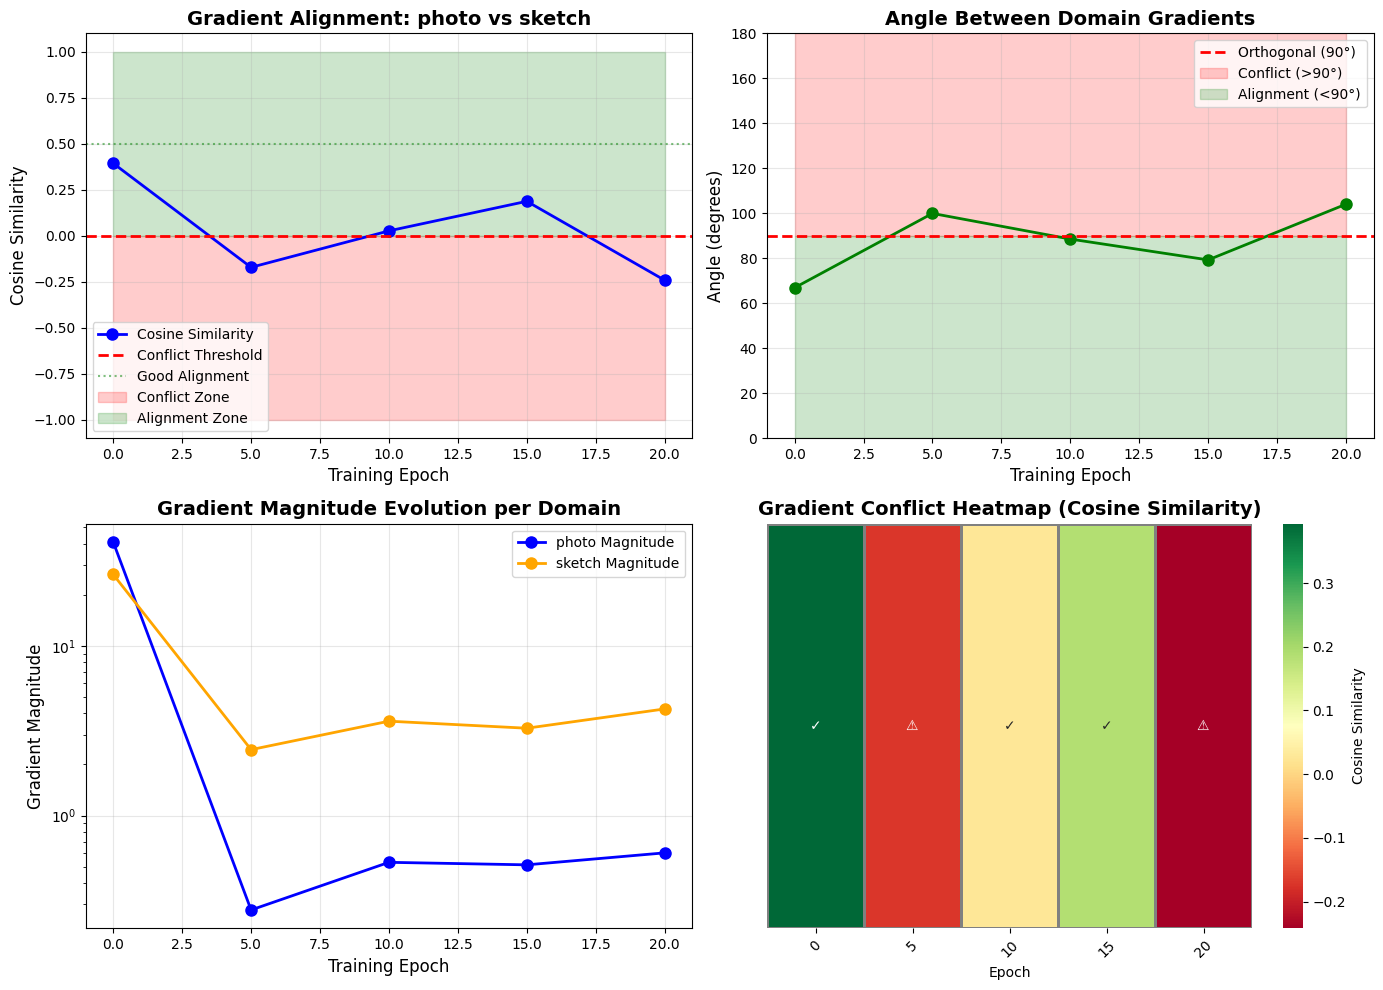


✅ Gradient conflict visualization complete!
Interpretation:
 - High cosine similarity → aligned optimization directions across domains.
 - Near-zero → orthogonal updates (little interference).
 - Negative similarity → conflicting gradients (optimization trade-off).


In [12]:
# ============================================================================
# Step 5: Visualize Results
# ============================================================================

print("\n" + "="*70)
print("Step 5: Visualizing gradient conflict patterns...")
print("="*70)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Cosine Similarity over Training
ax1 = axes[0, 0]
epochs = gradient_history['epoch']
cos_sims = gradient_history['cosine_sim']

ax1.plot(epochs, cos_sims, 'b-o', linewidth=2, markersize=8, label='Cosine Similarity')
ax1.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Conflict Threshold')
ax1.axhline(y=0.5, color='green', linestyle=':', alpha=0.5, label='Good Alignment')
ax1.fill_between(epochs, -1, 0, alpha=0.2, color='red', label='Conflict Zone')
ax1.fill_between(epochs, 0, 1, alpha=0.2, color='green', label='Alignment Zone')

ax1.set_xlabel('Training Epoch', fontsize=12)
ax1.set_ylabel('Cosine Similarity', fontsize=12)
ax1.set_title(f'Gradient Alignment: {DOMAIN_A} vs {DOMAIN_B}', fontsize=14, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.set_ylim([-1.1, 1.1])

# Plot 2: Angle between Gradients
ax2 = axes[0, 1]
angles = gradient_history['angle']

ax2.plot(epochs, angles, 'g-o', linewidth=2, markersize=8)
ax2.axhline(y=90, color='red', linestyle='--', linewidth=2, label='Orthogonal (90°)')
ax2.fill_between(epochs, 90, 180, alpha=0.2, color='red', label='Conflict (>90°)')
ax2.fill_between(epochs, 0, 90, alpha=0.2, color='green', label='Alignment (<90°)')
ax2.set_xlabel('Training Epoch', fontsize=12)
ax2.set_ylabel('Angle (degrees)', fontsize=12)
ax2.set_title('Angle Between Domain Gradients', fontsize=14, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 180])

# Plot 3: Gradient Magnitude Evolution
ax3 = axes[1, 0]
mag_a = gradient_history['mag_a']
mag_b = gradient_history['mag_b']

ax3.plot(epochs, mag_a, 'b-o', linewidth=2, markersize=8, label=f'{DOMAIN_A} Magnitude')
ax3.plot(epochs, mag_b, 'orange', marker='o', linewidth=2, markersize=8, label=f'{DOMAIN_B} Magnitude')
ax3.set_xlabel('Training Epoch', fontsize=12)
ax3.set_ylabel('Gradient Magnitude', fontsize=12)
ax3.set_title('Gradient Magnitude Evolution per Domain', fontsize=14, fontweight='bold')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# Plot 4: Conflict Heatmap
ax4 = axes[1, 1]
conflict_values = ['Conflict' if c else 'Aligned' for c in gradient_history['conflict']]
conflict_colors = ['#ff6b6b' if c else '#6bffb0' for c in gradient_history['conflict']]

sns.heatmap(
    np.array([gradient_history['cosine_sim']]),
    annot=np.array([["⚠️" if c else "✓" for c in gradient_history['conflict']]]),
    fmt="",
    cmap="RdYlGn",
    cbar_kws={'label': 'Cosine Similarity'},
    ax=ax4,
    linewidths=1,
    linecolor='gray'
)
ax4.set_xticks(np.arange(len(epochs)) + 0.5)
ax4.set_xticklabels(epochs, rotation=45)
ax4.set_yticks([])
ax4.set_title('Gradient Conflict Heatmap (Cosine Similarity)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Epoch')

plt.tight_layout()
plt.show()

print("\n✅ Gradient conflict visualization complete!")
print("Interpretation:")
print(" - High cosine similarity → aligned optimization directions across domains.")
print(" - Near-zero → orthogonal updates (little interference).")
print(" - Negative similarity → conflicting gradients (optimization trade-off).")


In [5]:
# ============================================================================
# PART 5 (Corrected): OPEN-SET AND GENERALIZATION ANALYSIS
# This section fulfills Objective 3.4, fixing the CUDA error.
# ============================================================================
import random
import numpy as np
import matplotlib.pyplot as plt

print("\n" + "="*70)
print("PART 5: OPEN-SET AND GENERALIZATION ANALYSIS")
print("="*70)

# --- 1. Define Class Split ---
SEEN_RATIO = 0.8
random.seed(42)
shuffled_classes = random.sample(PACS_CLASSES, len(PACS_CLASSES))
split_idx = int(len(PACS_CLASSES) * SEEN_RATIO)

SEEN_CLASSES = sorted(shuffled_classes[:split_idx])
UNSEEN_CLASSES = sorted(shuffled_classes[split_idx:])

class_to_idx = {name: i for i, name in enumerate(PACS_CLASSES)}
SEEN_INDICES = {class_to_idx[name] for name in SEEN_CLASSES}

print(f"Seen classes ({len(SEEN_CLASSES)}): {SEEN_CLASSES}")
print(f"Unseen classes ({len(UNSEEN_CLASSES)}): {UNSEEN_CLASSES}")

# --- 2. Create Corrected Open-Set Datasets and Loaders ---
class OpenSetDataset(Dataset):
    """
    Filters a dataset by domain and class indices.
    Optionally remaps class labels for closed-set training.
    """
    def __init__(self, hf_dataset, domains, class_indices, include, transform=None, remap_labels=False):
        if not isinstance(domains, list):
            domains = [domains]

        self.dataset = hf_dataset.filter(
            lambda ex: (ex['domain'] in domains) and ((ex['label'] in class_indices) if include else (ex['label'] not in class_indices))
        )
        self.transform = transform
        self.remap_labels = remap_labels
        
        if self.remap_labels:
            # Map original index to new index (0 to N-1) based on sorted order
            self.class_map = {
                original_idx: new_idx 
                for new_idx, original_idx in enumerate(sorted(list(class_indices)))
            }
            print(f"Label remapping enabled. Map: {self.class_map}")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image'].convert("RGB")
        original_label = item['label']
        
        if self.transform:
            image = self.transform(image)
            
        final_label = self.class_map[original_label] if self.remap_labels else original_label
        return image, final_label

# Dataset for training (all source domains, only seen classes, labels remapped)
train_seen_dataset = OpenSetDataset(
    hf_dataset=full_dataset, 
    domains=SOURCE_DOMAINS, 
    class_indices=SEEN_INDICES, 
    include=True, 
    transform=clip_transform,
    remap_labels=True # Enable remapping for training
)

# Test dataset for seen classes (target domain, labels remapped)
test_seen_dataset = OpenSetDataset(
    hf_dataset=full_dataset, 
    domains=[TARGET_DOMAIN], 
    class_indices=SEEN_INDICES, 
    include=True, 
    transform=clip_transform,
    remap_labels=True # Enable remapping for evaluation
)

# Test dataset for unseen classes (target domain, original labels are fine)
test_unseen_dataset = OpenSetDataset(
    hf_dataset=full_dataset, 
    domains=[TARGET_DOMAIN], 
    class_indices=SEEN_INDICES, 
    include=False, 
    transform=clip_transform,
    remap_labels=False # No remapping needed
)

train_seen_loader = DataLoader(train_seen_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_seen_loader = DataLoader(test_seen_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_unseen_loader = DataLoader(test_unseen_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nTraining samples (seen classes, all source domains): {len(train_seen_dataset)}")
print(f"Test samples (seen classes, target domain): {len(test_seen_dataset)}")
print(f"Test samples (unseen OOD, target domain): {len(test_unseen_dataset)}")

# --- 3. Train Prompt Model on Seen Classes ---
print("\nTraining CoOp model on SEEN classes only...")
openset_coop_model = SafeCoOpPrompts(
    clip_model=clip_model,
    class_names=SEEN_CLASSES, # IMPORTANT: Model only knows about seen classes
    n_ctx=16,
    device=device
).to(device)

# This will now run without error because train_seen_loader provides remapped labels
trained_openset_coop = train_safe_coop(
    clip_model=clip_model,
    coop_model=openset_coop_model,
    train_loader=train_seen_loader,
    epochs=10,
    lr=0.002,
    device=device
)


PART 5: OPEN-SET AND GENERALIZATION ANALYSIS
Seen classes (5): ['dog', 'giraffe', 'horse', 'house', 'person']
Unseen classes (2): ['elephant', 'guitar']


Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Label remapping enabled. Map: {0: 0, 2: 1, 4: 2, 5: 3, 6: 4}


Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Label remapping enabled. Map: {0: 0, 2: 1, 4: 2, 5: 3, 6: 4}


Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]


Training samples (seen classes, all source domains): 4643
Test samples (seen classes, target domain): 2581
Test samples (unseen OOD, target domain): 1348

Training CoOp model on SEEN classes only...

Initializing Safe CoOp:
  Context tokens: 16
  Classes: 5
  Embedding dimension: 512
  Trainable parameters: 8,192
  EOS positions: [19, 19, 19, 19, 19]
  Initialization complete!

Training setup:
  Optimizing: 8,192 parameters
  Context requires_grad: True

Starting training for 10 epochs...


Epoch   1: Loss=0.1539, Acc=96.06%


Epoch  10: Loss=0.0217, Acc=99.35%


In [6]:
# --- 4. Define Corrected Open-Set Evaluation Function ---
def evaluate_open_set(clip_model, prompt_model, loader, domain_name, class_set_type, device='cuda'):
    """Evaluates accuracy on in-distribution and confidence on out-of-distribution data."""
    clip_model.eval()
    prompt_model.eval()
    
    correct = 0
    total = 0
    all_max_probs = []
    
    with torch.no_grad():
        text_features = prompt_model() # These are features for SEEN classes only
        
        for images, labels in tqdm(loader, desc=f"Eval open-set on {domain_name} ({class_set_type})"):
            images, labels = images.to(device), labels.to(device)
            
            image_features = clip_model.get_image_features(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            
            logits = 100.0 * image_features @ text_features.T
            probs = logits.softmax(dim=-1)
            max_probs, predicted_indices = probs.max(dim=-1)
            
            all_max_probs.extend(max_probs.cpu().numpy())
            total += labels.size(0)

            # CORRECTED: The loader now provides remapped labels directly for the 'Seen' case.
            if class_set_type == 'Seen':
                correct += predicted_indices.eq(labels).sum().item()

    avg_msp = np.mean(all_max_probs) if all_max_probs else 0
    
    if class_set_type == 'Seen':
        accuracy = 100. * correct / total
        print(f"  Accuracy on Seen Classes: {accuracy:.2f}%")
        print(f"  Avg. Max Softmax Probability (Confidence): {avg_msp:.4f}")
        return accuracy, avg_msp
    else: # Unseen
        # False Positive Rate: % of unseen samples with confidence > threshold
        fpr_95 = np.sum(np.array(all_max_probs) > 0.95) / total * 100
        print(f"  Avg. Max Softmax Probability (Confidence): {avg_msp:.4f}")
        print(f"  False Positive Rate @ 95% threshold: {fpr_95:.2f}%")
        return fpr_95, avg_msp



In [7]:
# --- 5. Run Evaluation ---
print("\n" + "-"*70)
print("Evaluating Tuned Prompt Model (CoOp) on Open Set")
print("-"*70)
print("Evaluating on SEEN test classes (In-Distribution)...")
acc_coop, msp_coop_seen = evaluate_open_set(clip_model, trained_openset_coop, test_seen_loader, TARGET_DOMAIN, 'Seen')

print("\nEvaluating on UNSEEN test classes (Out-of-Distribution)...")
fpr_coop, msp_coop_unseen = evaluate_open_set(clip_model, trained_openset_coop, test_unseen_loader, TARGET_DOMAIN, 'Unseen')

# --- 6. Analysis and Visualization ---
print("\n" + "="*70)
print("Open-Set Analysis Summary")
print("="*70)
print(f"Tuned Prompt (CoOp) Performance:")
print(f"  - Accuracy on Seen Classes: {acc_coop:.2f}%")
print(f"  - Avg. Confidence on Seen Classes: {msp_coop_seen:.4f}")
print(f"  - Avg. Confidence on Unseen Classes: {msp_coop_unseen:.4f}")
print(f"  - False Positive Rate @ 95% Confidence: {fpr_coop:.2f}%")
print("\nInterpretation:")
print("A well-calibrated open-set model should have high confidence on 'seen' data")
print("and low confidence on 'unseen' data, resulting in a low False Positive Rate (FPR).")
print("Prompt tuning can sometimes lead to overconfidence, increasing the FPR compared to zero-shot CLIP.")


----------------------------------------------------------------------
Evaluating Tuned Prompt Model (CoOp) on Open Set
----------------------------------------------------------------------
Evaluating on SEEN test classes (In-Distribution)...


Eval open-set on sketch (Seen): 100%|██████████| 41/41 [00:11<00:00,  3.62it/s]


  Accuracy on Seen Classes: 80.74%
  Avg. Max Softmax Probability (Confidence): 0.9254

Evaluating on UNSEEN test classes (Out-of-Distribution)...


Eval open-set on sketch (Unseen): 100%|██████████| 22/22 [00:05<00:00,  3.68it/s]

  Avg. Max Softmax Probability (Confidence): 0.6614
  False Positive Rate @ 95% threshold: 6.97%

Open-Set Analysis Summary
Tuned Prompt (CoOp) Performance:
  - Accuracy on Seen Classes: 80.74%
  - Avg. Confidence on Seen Classes: 0.9254
  - Avg. Confidence on Unseen Classes: 0.6614
  - False Positive Rate @ 95% Confidence: 6.97%

Interpretation:
A well-calibrated open-set model should have high confidence on 'seen' data
and low confidence on 'unseen' data, resulting in a low False Positive Rate (FPR).
Prompt tuning can sometimes lead to overconfidence, increasing the FPR compared to zero-shot CLIP.
